<a href="https://colab.research.google.com/github/sener7106/TiL/blob/main/ML220125.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 분류 프로젝트 - 타이타닉 희생자 분류


---
타겟 데이터와 관련이 있는 정보를 수집하는 것이 중요하다.


## 데이터 사전

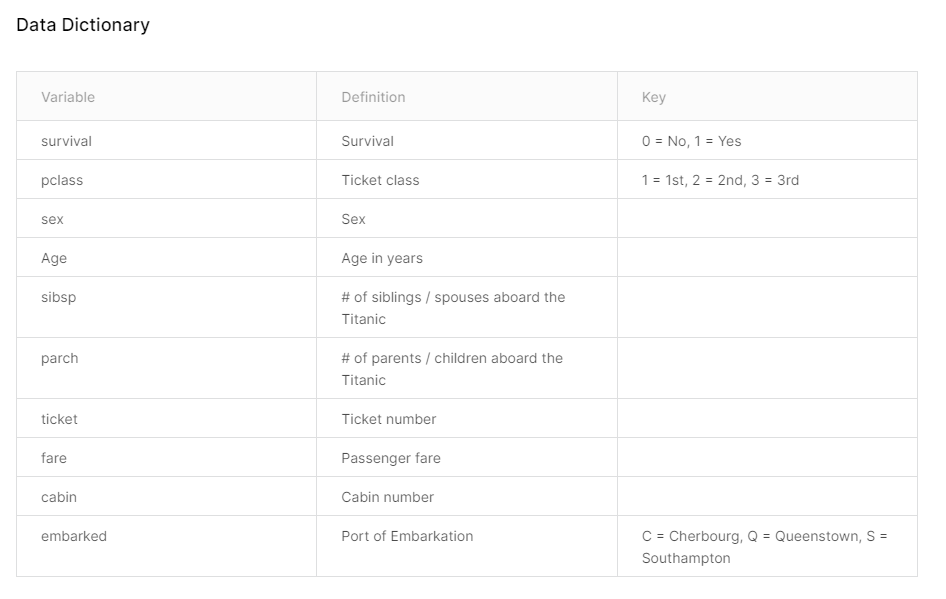

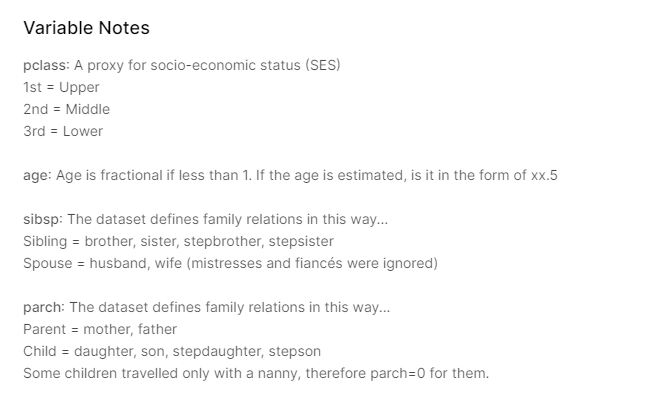

In [466]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
sns.set(font_scale = 2.5)

import warnings
warnings.filterwarnings("ignore")


In [467]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [468]:
csv_path = '/content/drive/MyDrive/ML_MacineLearning/train.csv'

In [469]:
df_titanic = pd.read_csv(csv_path)

In [470]:
df = df_titanic.copy()

In [471]:
df.head()

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

## 결측치 확인 및 데이터 정제

In [472]:
df.describe()

PassengerId    Survived      Pclass  ...       SibSp       Parch        Fare
count   891.000000  891.000000  891.000000  ...  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642  ...    0.523008    0.381594   32.204208
std     257.353842    0.486592    0.836071  ...    1.102743    0.806057   49.693429
min       1.000000    0.000000    1.000000  ...    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000  ...    0.000000    0.000000    7.910400
50%     446.000000    0.000000    3.000000  ...    0.000000    0.000000   14.454200
75%     668.500000    1.000000    3.000000  ...    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000  ...    8.000000    6.000000  512.329200

[8 rows x 7 columns]

In [473]:
df.shape

(891, 12)

In [474]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### null 값의 비율을 조회

In [475]:
df.isnull().sum() / len(df) 

# cabin(존재하지 않는 객실번호가 많이 존재함)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

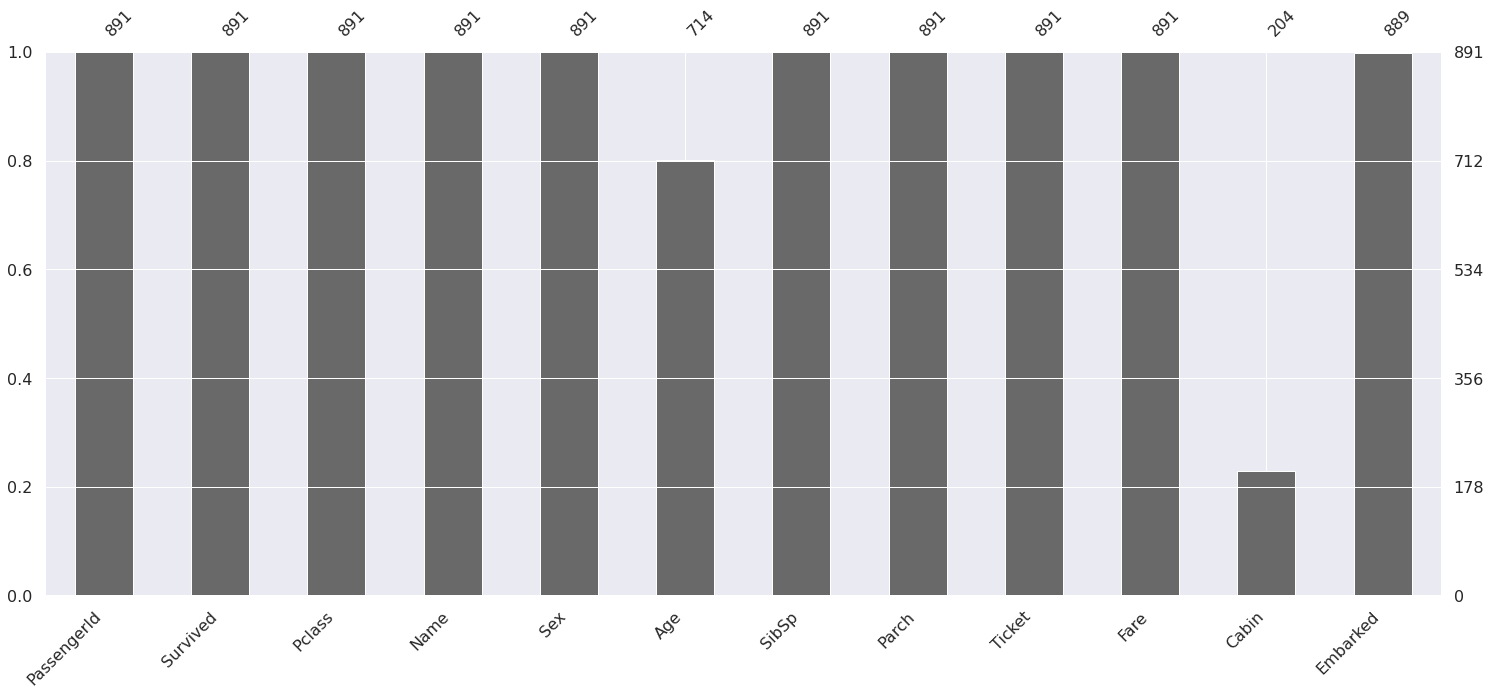

In [476]:
import missingno as msno

msno.bar(df)

## 생존과 관련된 컬럼을 검색
- 데이터 분석 시 생존과 관련 있는 컬럼들로 데이터 프레임을 구성해서 분석해야함
- 관련 없는 컬럼이 존재할 경우 정확도 감소
- 관련 있는 데이터라고 생각했지만 오히려 관련이 없을 수도 있음

In [477]:
train_target = df['Survived']

train_target.value_counts()

0    549
1    342
Name: Survived, dtype: int64

### P-class (티켓 등급) 와 생존률과의 관계 파악

In [478]:
# 타겟 클래스의 빈도수 조회

df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [479]:
# 각 줄의 생존자 여부를 조회하기 (Survived == 1)
# 조건에 해당하는 bool 리턴

In [480]:
df['Survived'] == 1

0      False
1       True
2       True
3       True
4      False
       ...  
886    False
887     True
888    False
889     True
890    False
Name: Survived, Length: 891, dtype: bool

In [481]:
# 생존한 사람들만을 조회

df[df['Survived'] == 1]['Pclass'].value_counts()

1    136
3    119
2     87
Name: Pclass, dtype: int64

In [482]:
list(df.groupby(['Sex', 'Pclass']))

[(('female', 1),
       PassengerId  Survived  Pclass  ...      Fare Cabin  Embarked
  1              2         1       1  ...   71.2833   C85         C
  3              4         1       1  ...   53.1000  C123         S
  11            12         1       1  ...   26.5500  C103         S
  31            32         1       1  ...  146.5208   B78         C
  52            53         1       1  ...   76.7292   D33         C
  ..           ...       ...     ...  ...       ...   ...       ...
  856          857         1       1  ...  164.8667   NaN         S
  862          863         1       1  ...   25.9292   D17         S
  871          872         1       1  ...   52.5542   D35         S
  879          880         1       1  ...   83.1583   C50         C
  887          888         1       1  ...   30.0000   B42         S
  
  [94 rows x 12 columns]),
 (('female', 2),
       PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
  9             10         1       2  ...  30.0708   

### Pclass칸과 Survived를 교차해서 빈도수를 출력하기

In [483]:
# pd.crosstab(col1, col2, margins = 합계를 출력하고자 하면 True)
# 트리 알고리즘은 크게 데이터에 영향을 받지 않지만, L.R, Ridge, Lasso의 경우 어떤 컬럼을 구성하는게 중요
pd.crosstab(df['Pclass'], df['Survived'], margins = True)

Survived    0    1  All
Pclass                 
1          80  136  216
2          97   87  184
3         372  119  491
All       549  342  891

### 성별에 따른 생존률의 관계를 파악

In [484]:
df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [485]:
pd.crosstab(df['Sex'], df['Survived'], margins = True)

Survived    0    1  All
Sex                    
female     81  233  314
male      468  109  577
All       549  342  891

In [486]:
df.groupby(['Sex', 'Pclass']).mean()[['Survived']]

# 평균을 통해 생존률을 알 수 있음

Survived
Sex    Pclass          
female 1       0.968085
       2       0.921053
       3       0.500000
male   1       0.368852
       2       0.157407
       3       0.135447

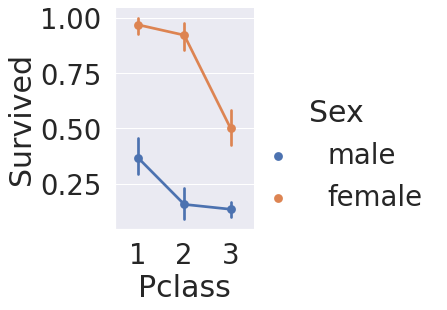

In [487]:
sns.factorplot('Pclass', 'Survived', hue = 'Sex', data = df)

In [488]:
# 1등석 중 여성의 생존확률이 압도적으로 높고, 3등석의 승객은 여자가 높았으나, 전체적으로 살아남은 비율이 적었음.

### Age 컬럼과 생존률 간의 관계

In [489]:
survived_age = df[df['Survived'] == 1][['Age']]
survived_age = df['Age'][df['Survived'] == 1]

In [490]:
survived_age

1      38.0
2      26.0
3      35.0
8      27.0
9      14.0
       ... 
875    15.0
879    56.0
880    25.0
887    19.0
889    26.0
Name: Age, Length: 342, dtype: float64

In [491]:
dead_age = df[df['Survived'] != 1][['Age']]
dead_age = df['Age'][df['Survived'] != 1]

In [492]:
dead_age.mean()

30.62617924528302

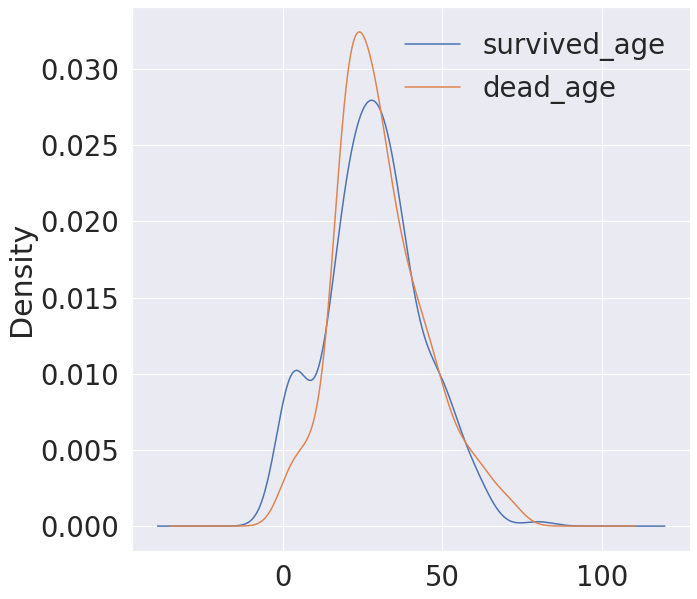

In [493]:
# age 컬럼에서 각 나이별 survived_age 와 dead_age간의 비율을 그래프로 그림

plt.figure(figsize = (10, 10))
# 데이터 plot(kind = 'kde') 는 비율을 그려줌
survived_age.plot(kind = 'kde')
dead_age.plot(kind = 'kde')
plt.legend(['survived_age', 'dead_age'])
plt.show()

# KDE = kernel density estimation , 확률밀도함수로 표현 모분산

In [494]:
survived_age.describe()

count    290.000000
mean      28.343690
std       14.950952
min        0.420000
25%       19.000000
50%       28.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

In [495]:
dead_age.describe()

count    424.000000
mean      30.626179
std       14.172110
min        1.000000
25%       21.000000
50%       28.000000
75%       39.000000
max       74.000000
Name: Age, dtype: float64

In [496]:
plt.style.use('seaborn')

In [497]:
# plt.scatter(x = range(len(survived_age)), y = survived_age['Age'])

### Embarked 컬럼과 생존률 간의 관계

In [498]:
pd.crosstab(df['Embarked'], df['Survived'], margins = True)

Survived    0    1  All
Embarked               
C          75   93  168
Q          47   30   77
S         427  217  644
All       549  340  889

In [499]:
pd.crosstab(df['Embarked'], df['Pclass'], margins = True)

Pclass      1    2    3  All
Embarked                    
C          85   17   66  168
Q           2    3   72   77
S         127  164  353  644
All       214  184  491  889

In [500]:
# class 로 스플릿 해보았을 때, C가 생존률이 높은 이유는 클래스가 높은 사람이 많이 탑승해서, 반대로 S는 3rd class의 비율이 많음

## 상관관계 분석

- 상관관계 분석은 두 변수간 어떤 상관관계를 갖는지 확인하기 위함.
- 이 때 두 변수간 관계가 있는 가를 측정하는 단순 상관분석,연 다변수를 분석하는 다중상관분석이라고 함.
- 연속형(시계열) 수치로 이루어진 변수와 변수 사이의 관계를 말함

In [501]:
df.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

- pclass와 음의 상관관계, fare와 양의 상관관계ㅡ

### 각 컬럼의 기울어진 정도를 표현

In [502]:
df.skew()

PassengerId    0.000000
Survived       0.478523
Pclass        -0.630548
Age            0.389108
SibSp          3.695352
Parch          2.749117
Fare           4.787317
dtype: float64

(array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <a list of 10 Patch objects>)

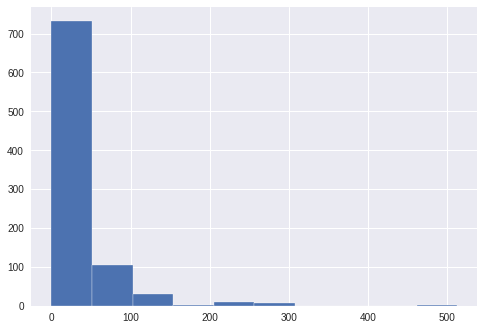

In [503]:
# 가장 기울어진 컬럼을 시각화

plt.hist(df['Fare'])

(array([678., 118.,   0.,  80.,   0.,   5.,   4.,   0.,   5.,   1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

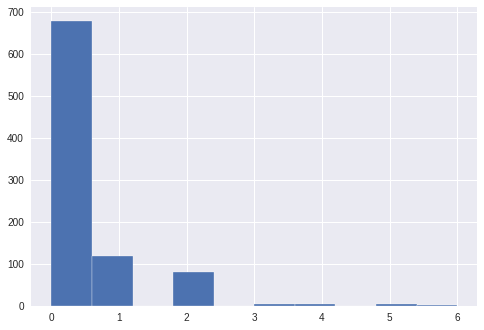

In [504]:
plt.hist(df['Parch'])

- distribution 이 매우 비대칭인 것을 확인 가능, 만약 이대로 모델에 넣어준다면 모델이 잘못 예측할 수가 있음
- outlier에 대해 민감하게 반응하면 실제 예측 결과에 부정적 영향을 미칠 수 있음

- outlier에 대해 영향을 주기 위해서 fare에 log를 취함

(array([ 15.,   0.,   2., 350., 167., 182.,  85.,  59.,  28.,   3.]),
 array([0.        , 0.62409174, 1.24818347, 1.87227521, 2.49636694,
        3.12045868, 3.74455041, 4.36864215, 4.99273388, 5.61682562,
        6.24091735]),
 <a list of 10 Patch objects>)

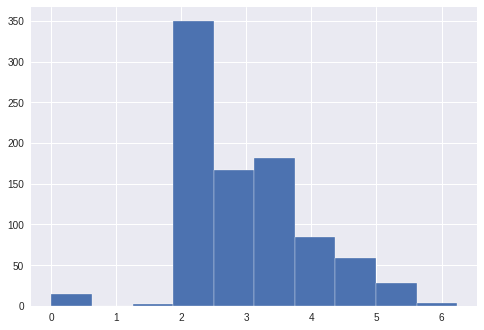

In [505]:
plt.hist(np.log1p(df['Fare']))

In [506]:
df['Fare'] = np.log1p(df['Fare'])

## 데이터 전처리

### 가족과 함께 탑승한 승객과 혼자 탑승한 승객을 비교하고 가족 수와 생존 간 관계를 파악

In [507]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [508]:
pd.crosstab(df['FamilySize'], df['Survived'], margins = True) # 11 -> 이민간 사람 비율

Survived      0    1  All
FamilySize               
1           374  163  537
2            72   89  161
3            43   59  102
4             8   21   29
5            12    3   15
6            19    3   22
7             8    4   12
8             6    0    6
11            7    0    7
All         549  342  891

In [509]:
# 3~4명인 가족이 생존률이더 높은 것을 확인 할 수 있음

In [510]:
df['FamilySize'].mean()

1.904601571268238

### Sir 컬럼 추가
- 성별, 나이가 생존률과 관계를 가짐을 알 수 있었음.
- 성별과 나이를 나타내는 컬럼을 추가

- 이름에서 여자의 경우 미혼인 경우 기혼인 경우보다 나이가 어릴 것으로 예상, Miss, mrs 등의 값을 찾는 컬럼 추가  
- 남자의 경우, Mr(성년), Master(도련님) 등의 값을 찾는 컬럼 추가

In [511]:
# name_list를 컬럼으로 변환

name_list = list(df['Name'])

In [512]:
import re
# 다음 단어 중 하나를 포함하는 문자열을 찾기 위한 객체 p 생성
p = re.compile('Mrs|Mr|Miss|Master|Dr|Ms|Major|Mlle|Mme|Countess|Lady|Don|Countess')

In [513]:
p

re.compile(r'Mrs|Mr|Miss|Master|Dr|Ms|Major|Mlle|Mme|Countess|Lady|Don|Countess',
re.UNICODE)

In [514]:
for name in name_list :
  # p에 대입하는 문자열과 name이 일치하는 문자열을 리턴받아 출력
  # 일치하는 문자열과 name에 일치하는 문자열이 없으면 에러 발생
  if p.search(name) != None :
    print(p.search(name)[0])
  else :
    print('Other')


Mr
Mrs
Miss
Mrs
Mr
Mr
Mr
Master
Mrs
Mrs
Miss
Miss
Mr
Mr
Miss
Mrs
Master
Mr
Mrs
Mrs
Mr
Mr
Miss
Mr
Miss
Mrs
Mr
Mr
Miss
Mr
Don
Mrs
Miss
Mr
Mr
Mr
Mr
Mr
Miss
Miss
Mrs
Mrs
Mr
Miss
Miss
Mr
Mr
Dr
Mr
Mrs
Master
Mr
Mrs
Mrs
Mr
Mr
Miss
Mr
Miss
Master
Mr
Miss
Mr
Master
Mr
Master
Mrs
Mr
Miss
Mr
Mr
Miss
Mr
Mr
Mr
Mr
Mr
Mr
Master
Miss
Mr
Mr
Miss
Mr
Miss
Mrs
Mr
Mr
Miss
Mr
Mr
Mr
Mr
Mr
Mr
Mr
Mr
Mr
Mrs
Mr
Miss
Mr
Mr
Mr
Mr
Mr
Miss
Mr
Mr
Miss
Mr
Miss
Mr
Miss
Miss
Mr
Mr
Mr
Mr
Miss
Mr
Mr
Mr
Miss
Mr
Master
Mr
Mr
Miss
Mr
Dr
Mr
Mrs
Mrs
Mr
Mr
Miss
Mr
Mr
Mr
Mrs
Miss
Mrs
Mr
Mr
Mr
Mr
Miss
Mr
Other
Other
Mrs
Mr
Mr
Mr
Mr
Miss
Mr
Mr
Master
Mr
Mrs
Mr
Mr
Master
Master
Mrs
Mrs
Mr
Mr
Mr
Master
Miss
Mr
Mr
Mr
Master
Miss
Mr
Mr
Miss
Mr
Master
Master
Miss
Mr
Mrs
Mr
Mr
Mr
Mrs
Mr
Miss
Master
Mrs
Miss
Mr
Mr
Miss
Miss
Mr
Mr
Mr
Mr
Mr
Miss
Mr
Mr
Miss
Mr
Mr
Miss
Mr
Mr
Mr
Miss
Miss
Mr
Miss
Mr
Mr
Mr
Mr
Mr
Mr
Mr
Mr
Mr
Mr
Miss
Mrs
Mr
Mr
Miss
Mr
Miss
Mr
Miss
Mr
Mr
Miss
Miss
Mr
Mr
Mr
Dr
Miss
Mrs
Mr
Other
Mr
Mrs
Mr
Mr
Mrs
Mrs
Mrs
Miss
Miss
M

- 기혼 여성에 해당하는 Countess, Lady, Mrs 를 Mrs로 변경
- 미혼여성을 지칭하는 Mme, Ms, Mlle를 Miss로 변경
- 성인남성을 지칭하는 Don, Dr, Major를 Mr로 변경

In [515]:
sir = []
for name in name_list :
  if p.search(name) is not None :
    if p.search(name)[0] in ['Countess', 'Lady', 'Mrs'] :
      # slr에 미세스 추가
      sir.append('Mrs')
    elif p.search(name)[0] in ['Mme', 'Ms', 'Mlle'] :
      sir.append('Miss')
    elif p.search(name)[0] in ['Don', 'Dr', 'Major'] :
      sir.append('Mr')
    else :
      sir.append(p.search(name)[0])
  else :
    sir.append('Other')


In [516]:
df['Sir'] = sir

In [517]:
df['Sir'].value_counts()

Mr        530
Miss      185
Mrs       126
Master     40
Other      10
Name: Sir, dtype: int64

In [518]:
# Sir와 Survived의 빈도수를 교차 출력
pd.crosstab(df['Sir'], df['Survived'], margins = True)

Survived    0    1  All
Sir                    
Master     17   23   40
Miss       55  130  185
Mr        442   88  530
Mrs        26  100  126
Other       9    1   10
All       549  342  891

## 결측치 처리

### 나이 결측치를 처리 

- 기혼여성이 미혼 여성보다 나이가 많을 것으로 예상
- Master(도련님, 귀족집안의 미성년남자) 의 나이는 어릴것 

- 나이가 결측치인 행은 Sir 컬럼의값을 참조해서 같은 Sir 값으로 평균을 취함

In [519]:
df.groupby('Sir').mean()

PassengerId  Survived    Pclass  ...     Parch      Fare  FamilySize
Sir                                      ...                                
Master   414.975000  0.575000  2.625000  ...  1.375000  3.381361    4.675000
Miss     413.708108  0.702703  2.281081  ...  0.540541  3.192351    2.243243
Mr       454.490566  0.166038  2.384906  ...  0.150943  2.728141    1.443396
Mrs      456.706349  0.793651  1.984127  ...  0.817460  3.485083    2.507937
Other    582.600000  0.100000  1.600000  ...  0.200000  2.848635    1.400000

[5 rows x 8 columns]

In [520]:
df.groupby('Sir').mean()['Age']

# 각 해당되는 나이의 평균

Sir
Master     4.574167
Miss      21.860000
Mr        32.651589
Mrs       36.000000
Other     48.300000
Name: Age, dtype: float64

In [521]:
# Sir 컬럼의 값이 'Mrs'의 평균
df.groupby('Sir').mean().loc['Mrs']

PassengerId    456.706349
Survived         0.793651
Pclass           1.984127
Age             36.000000
SibSp            0.690476
Parch            0.817460
Fare             3.485083
FamilySize       2.507937
Name: Mrs, dtype: float64

In [522]:
# Sir 컬럼의 값이 'Mrs' 의 나이 평균
df.groupby('Sir').mean().loc['Mrs']['Age']

36.0

In [523]:
# Sir 컬럼을 기준으로 평균을 계산하여  sir_df에 대입하기
sir_df = df.groupby('Sir').mean()

In [524]:
sir_df

PassengerId  Survived    Pclass  ...     Parch      Fare  FamilySize
Sir                                      ...                                
Master   414.975000  0.575000  2.625000  ...  1.375000  3.381361    4.675000
Miss     413.708108  0.702703  2.281081  ...  0.540541  3.192351    2.243243
Mr       454.490566  0.166038  2.384906  ...  0.150943  2.728141    1.443396
Mrs      456.706349  0.793651  1.984127  ...  0.817460  3.485083    2.507937
Other    582.600000  0.100000  1.600000  ...  0.200000  2.848635    1.400000

[5 rows x 8 columns]

In [525]:
# age 컬럼이 null인 행의 데이터를 Sir값이 일치하는 행의 평균으로 치환하는 함수
# age 컬럼이 null인 줄인 인덱스 ; index

def process_age_null(index, df) :
  # 인덱스에 해당하는 줄의 Sir 칸의 데이터를 row_sir에 대입
  row_sir = df.loc[index]['Sir']
  print('index : ', index, 'row_sir', row_sir)
  # sir_df 에서 row_sir의 나이에 해당하는 평균을 sir_mean에 대입
  sir_mean = sir_df.loc[row_sir]['Age']
  print("sir_mean", sir_mean)
  # sir_mean을 index 번째 줄의 Age칸에 대입
  df.at[index, 'Age'] = sir_mean

In [526]:
#age 칸이 null인 줄을 조회
df['Age'].isnull()

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888     True
889    False
890    False
Name: Age, Length: 891, dtype: bool

In [527]:
age_null_idx = df.index[df['Age'].isnull()]

In [528]:
age_null_idx

Int64Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
            ...
            832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
           dtype='int64', length=177)

In [529]:
for idx in age_null_idx : 
  process_age_null(idx, df)

index :  5 row_sir Mr
sir_mean 32.65158924205379
index :  17 row_sir Mr
sir_mean 32.65158924205379
index :  19 row_sir Mrs
sir_mean 36.0
index :  26 row_sir Mr
sir_mean 32.65158924205379
index :  28 row_sir Miss
sir_mean 21.86
index :  29 row_sir Mr
sir_mean 32.65158924205379
index :  31 row_sir Mrs
sir_mean 36.0
index :  32 row_sir Miss
sir_mean 21.86
index :  36 row_sir Mr
sir_mean 32.65158924205379
index :  42 row_sir Mr
sir_mean 32.65158924205379
index :  45 row_sir Mr
sir_mean 32.65158924205379
index :  46 row_sir Mr
sir_mean 32.65158924205379
index :  47 row_sir Mr
sir_mean 32.65158924205379
index :  48 row_sir Mr
sir_mean 32.65158924205379
index :  55 row_sir Mr
sir_mean 32.65158924205379
index :  64 row_sir Mr
sir_mean 32.65158924205379
index :  65 row_sir Master
sir_mean 4.574166666666667
index :  76 row_sir Mr
sir_mean 32.65158924205379
index :  77 row_sir Mr
sir_mean 32.65158924205379
index :  82 row_sir Miss
sir_mean 21.86
index :  87 row_sir Mr
sir_mean 32.65158924205379
i

In [530]:
# age 값이 nan인 지점이 모두 수정됨
df.loc[5]

PassengerId                   6
Survived                      0
Pclass                        3
Name           Moran, Mr. James
Sex                        male
Age                     32.6516
SibSp                         0
Parch                         0
Ticket                   330877
Fare                    2.24689
Cabin                       NaN
Embarked                      Q
FamilySize                    1
Sir                          Mr
Name: 5, dtype: object

### Embarked 결측치를 처리

In [531]:
sum(df['Embarked'].isnull())

2

In [532]:
# Embarked가 null인  행에 S를 대입
df['Embarked'].fillna('S', inplace = True)

In [533]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
FamilySize       0
Sir              0
dtype: int64

## 분류 분석을 위한 데이터 처리
- 범주형 데이터 : 컬럼에 숫자가 아닌 문자가 저장, 범주형 데이터는 반드시 숫자값으로 전환해야함.

#### Age 컬럼처리

In [534]:
def category_age(age) :
  return age // 10

In [535]:
# 23세를 나이를 10으로 나눈 몪 계산
category_age(23)

2

In [536]:
# 컬럼.apply(함수) : 컬럼의 각 데이터마다 함수를 실행해서 결과를 더함
df['Age_cat']= df['Age'].apply(category_age)
df['Age_cat']

0      2.0
1      3.0
2      2.0
3      3.0
4      3.0
      ... 
886    2.0
887    1.0
888    2.0
889    2.0
890    3.0
Name: Age_cat, Length: 891, dtype: float64

In [537]:
# continuous 데이터를 categorical로 바꾸면 information loss(정보손실)이 일어날 수도 있지만 다양한 방법소개를 위해 생략

In [538]:
df

PassengerId  Survived  Pclass  ... FamilySize    Sir  Age_cat
0              1         0       3  ...          2     Mr      2.0
1              2         1       1  ...          2    Mrs      3.0
2              3         1       3  ...          1   Miss      2.0
3              4         1       1  ...          2    Mrs      3.0
4              5         0       3  ...          1     Mr      3.0
..           ...       ...     ...  ...        ...    ...      ...
886          887         0       2  ...          1  Other      2.0
887          888         1       1  ...          1   Miss      1.0
888          889         0       3  ...          4   Miss      2.0
889          890         1       1  ...          1     Mr      2.0
890          891         0       3  ...          1     Mr      3.0

[891 rows x 15 columns]

#### Sir 컬럼 처리

In [539]:
df['Sir'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

In [540]:
list(enumerate(df['Sir'].unique()))

[(0, 'Mr'), (1, 'Mrs'), (2, 'Miss'), (3, 'Master'), (4, 'Other')]

In [541]:
for data in enumerate(df['Sir'].unique()) :
  print("index: ", data[0], ",data : ", data[1])
  df['Sir'].replace(data[1], data[0], inplace = True)

index:  0 ,data :  Mr
index:  1 ,data :  Mrs
index:  2 ,data :  Miss
index:  3 ,data :  Master
index:  4 ,data :  Other


In [542]:
df['Sir'].head()

0    0
1    1
2    2
3    1
4    0
Name: Sir, dtype: int64

In [543]:
df['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [544]:
list(enumerate(df['Embarked'].unique()))

[(0, 'S'), (1, 'C'), (2, 'Q')]

In [545]:
for data in enumerate(df['Embarked'].unique()) :
  print("index: ", data[0], ",data : ", data[1])
  df['Embarked'].replace(data[1], data[0], inplace = True)

index:  0 ,data :  S
index:  1 ,data :  C
index:  2 ,data :  Q


In [546]:
df['Embarked'].head()

0    0
1    1
2    0
3    0
4    0
Name: Embarked, dtype: int64

In [547]:
for data in enumerate(df['Sex'].unique()) :
  print("index: ", data[0], ",data : ", data[1])
  df['Sex'].replace(data[1], data[0], inplace = True)

index:  0 ,data :  male
index:  1 ,data :  female


In [548]:
df['Sex'].head()

0    0
1    1
2    1
3    1
4    0
Name: Sex, dtype: int64

## 관계성이 적은 데이터 삭제

In [549]:
df.head(1)

PassengerId  Survived  Pclass  ... FamilySize  Sir  Age_cat
0            1         0       3  ...          2    0      2.0

[1 rows x 15 columns]

In [550]:
# 관련 없는 컬럼 삭제
df.drop(['PassengerId', 'Name', 'Cabin', 'Ticket', 'Age'], axis = 1, inplace = True)

In [551]:
df

Survived  Pclass  Sex  SibSp  ...  Embarked  FamilySize  Sir  Age_cat
0           0       3    0      1  ...         0           2    0      2.0
1           1       1    1      1  ...         1           2    1      3.0
2           1       3    1      0  ...         0           1    2      2.0
3           1       1    1      1  ...         0           2    1      3.0
4           0       3    0      0  ...         0           1    0      3.0
..        ...     ...  ...    ...  ...       ...         ...  ...      ...
886         0       2    0      0  ...         0           1    4      2.0
887         1       1    1      0  ...         0           1    2      1.0
888         0       3    1      1  ...         0           4    2      2.0
889         1       1    0      0  ...         1           1    0      2.0
890         0       3    0      0  ...         2           1    0      3.0

[891 rows x 10 columns]

## 분류

In [552]:
from sklearn.model_selection import train_test_split

In [553]:
y_label = df['Survived']
df.drop('Survived', axis = 1, inplace = True)

In [554]:
print(y_label.shape, df.shape)

(891,) (891, 9)


In [555]:
X_train, X_test, y_train, y_test = train_test_split(df, y_label, random_state = 156)

### 분류 알고리즘 - Decision Tree

In [556]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from IPython.display import Image

In [557]:
dt_clf = DecisionTreeClassifier()

In [558]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [559]:
dt_prediction = dt_clf.predict(X_test)

In [560]:
y_test

748    0
847    0
760    0
35     0
871    1
      ..
476    0
175    0
379    0
371    0
178    0
Name: Survived, Length: 223, dtype: int64

In [561]:
from sklearn.metrics import confusion_matrix

In [562]:
confusion_matrix(y_test, dt_prediction, labels = [1, 0])

array([[ 65,  21],
       [ 18, 119]])

In [563]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, dt_prediction)

print("Accuracy : ", accuracy)

Accuracy :  0.8251121076233184


In [564]:
feature_names = df.columns.tolist()
feature_names

['Pclass',
 'Sex',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked',
 'FamilySize',
 'Sir',
 'Age_cat']

In [565]:
# 결과의 이름을 설정
target_names = np.array(['Dead', 'Survive'])

In [566]:
dt_dot_data = tree.export_graphviz(dt_clf, out_file = None,
                                   feature_names = feature_names,
                                   class_names = target_names,
                                   filled = True, rounded = True,
                                   special_characters = True)

In [567]:
import pydotplus

In [568]:
dt_graph = pydotplus.graph_from_dot_data(dt_dot_data)

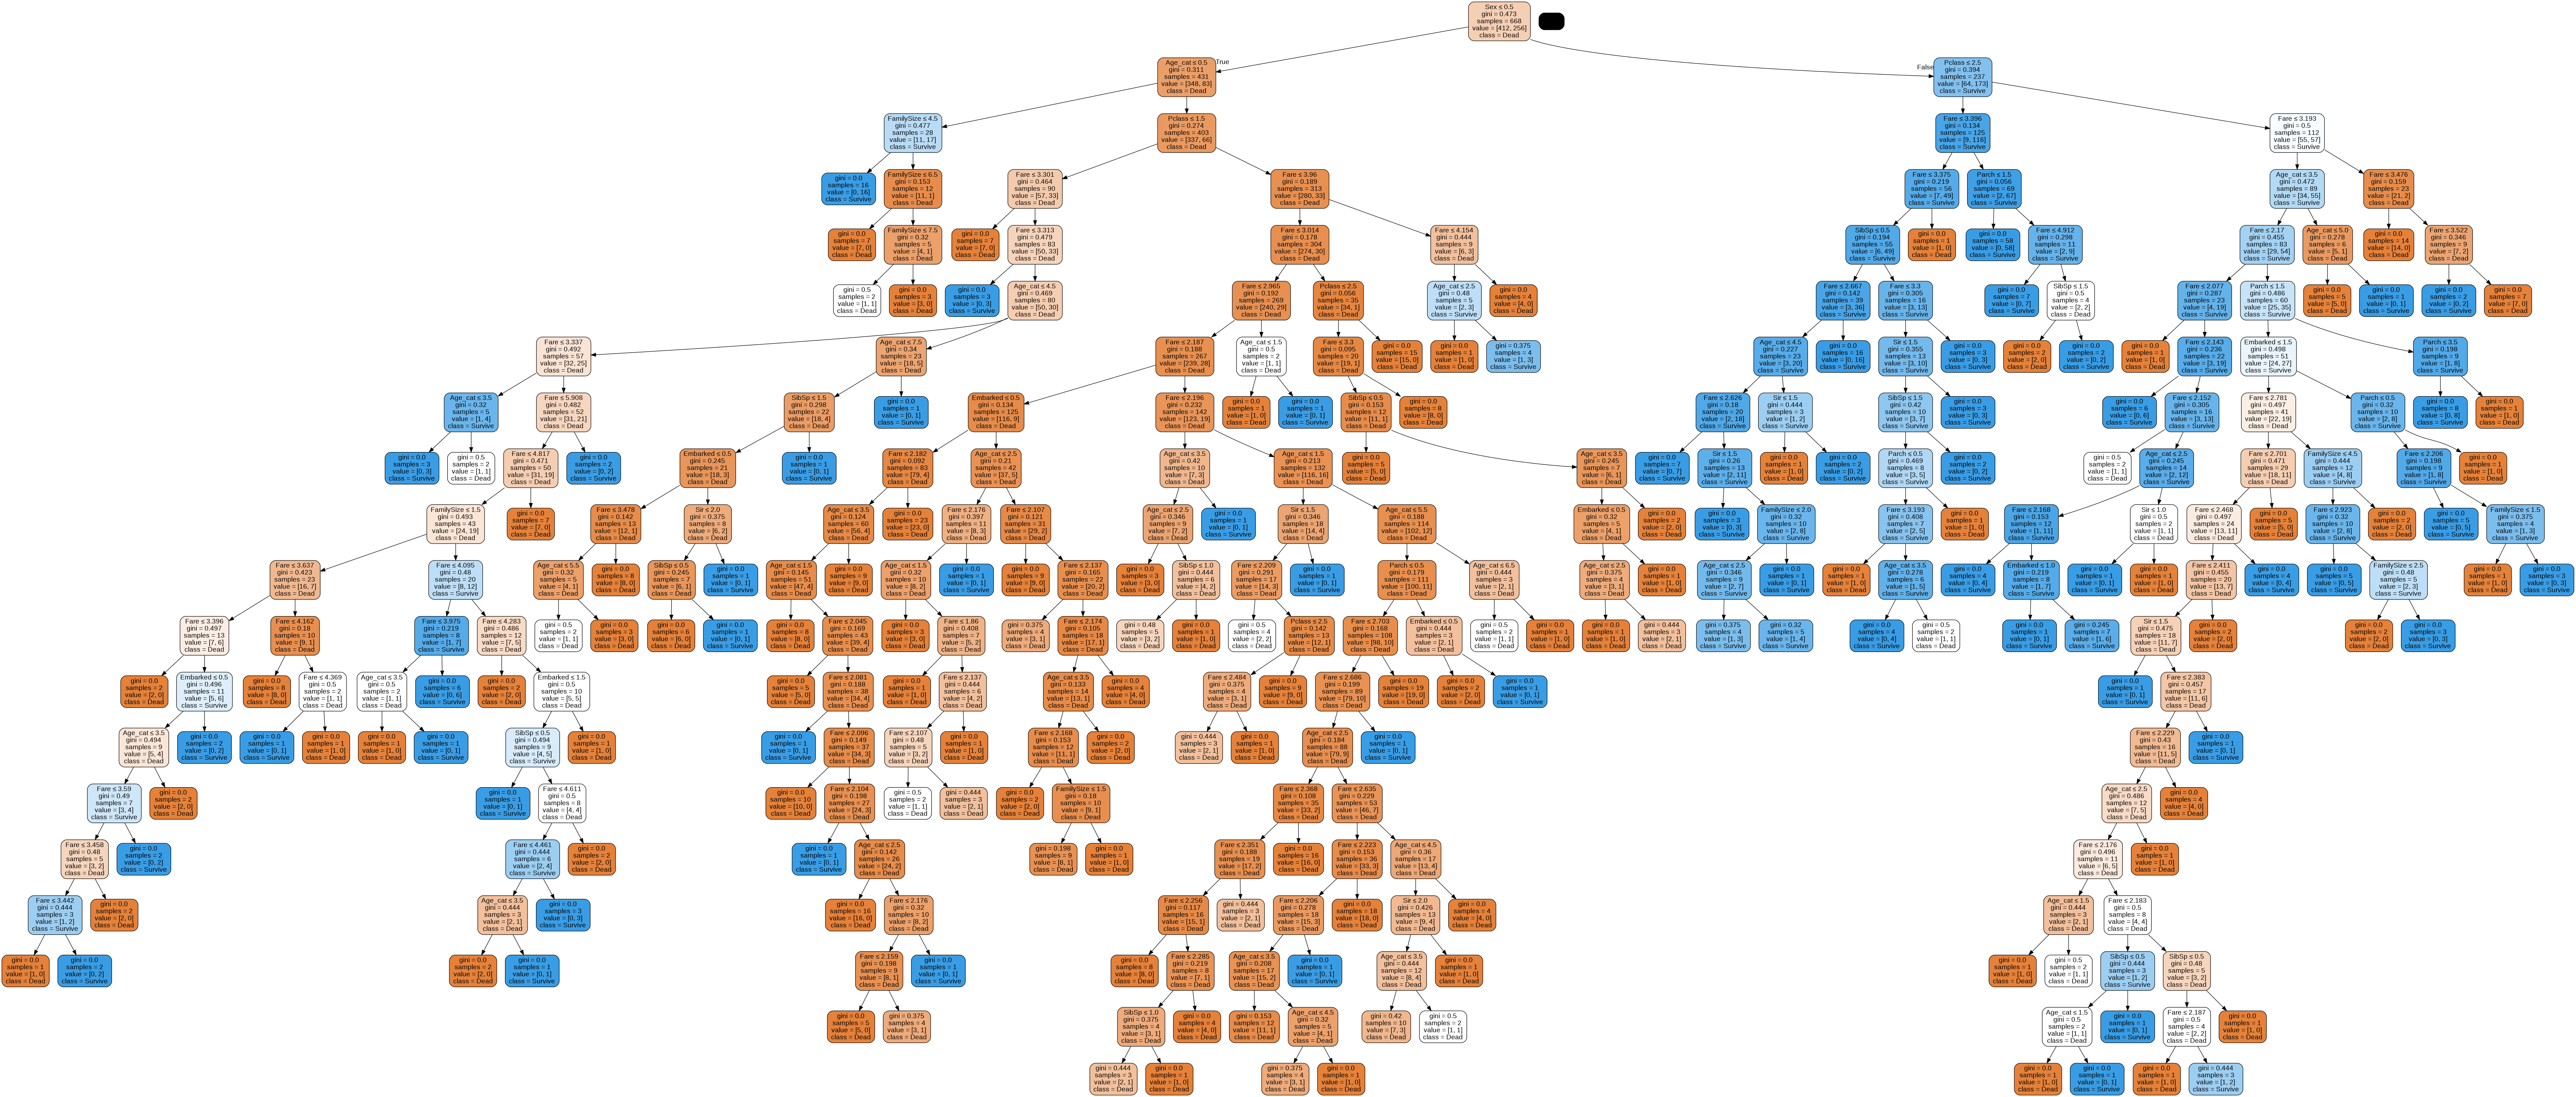

In [569]:
Image(dt_graph.create_png())

In [570]:
dt_graph.write_pdf('titanic.pdf')

True

### 분류 알고리즘 - XGboost

In [571]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# XGBoost 객체 생성
# 트리의 개수 500

xgb_clf = XGBClassifier()

# 트리의 파라미터 대입
params = {'max_depth' : [5, 7, 9, 11], 'min_child_weight' : [1, 3,5, 7], 'colsample_bytree' : [0.5,0.75,1.0]}

# XGboost의 최적의 패러미터를 찾기
gridcv = GridSearchCV(xgb_clf, param_grid = params)

In [572]:
gridcv.fit(X_train, y_train,
           early_stopping_rounds = 30,
           eval_metric = 'error',
           eval_set = [(X_train, y_train), (X_test, y_test)])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[69]	validation_0-error:0.112275	validation_1-error:0.161435
Stopping. Best iteration:
[39]	validation_0-error:0.116766	validation_1-error:0.152466

[0]	validation_0-error:0.172156	validation_1-error:0.183857
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.172156	validation_1-error:0.183857
[2]	validation_0-error:0.172156	validation_1-error:0.183857
[3]	validation_0-error:0.164671	validation_1-error:0.201794
[4]	validation_0-error:0.164671	validation_1-error:0.201794
[5]	validation_0-error:0.149701	validation_1-error:0.183857
[6]	validation_0-error:0.149701	validation_1-error:0.179372
[7]	validation_0-error:0.146707	validation_1-error:0.179372
[8]	validation_0-error:0.148204	validation_1-error:0.174888
[9]	validation_0-error:0.14521	validation_1-error:0.174888
[10]	validation_0-error:0.142216	validation_1-error:0.1

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'colsample_bytree': [0.5, 0.75, 1.0],
                         'max_depth': [5, 7, 9, 11],
                         'min_child_weight': [1, 3, 5, 7]})

In [573]:
gridcv.best_params_

{'colsample_bytree': 1.0, 'max_depth': 7, 'min_child_weight': 3}

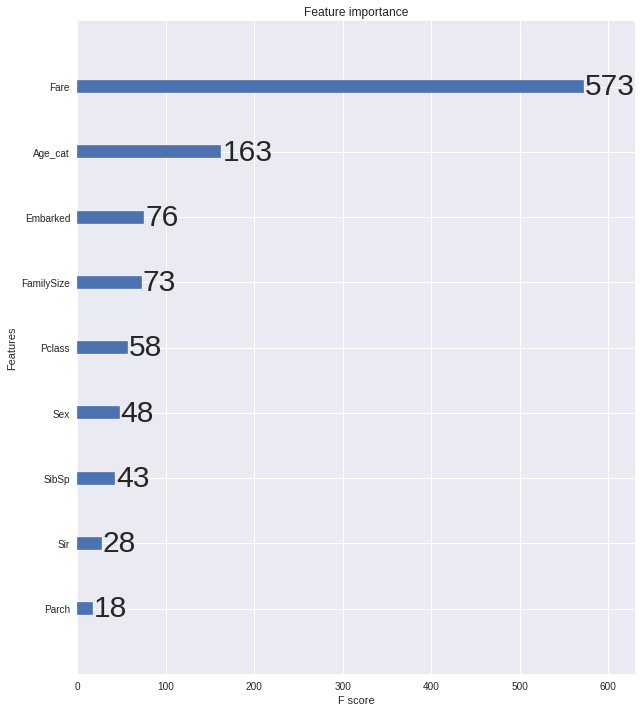

In [574]:
from xgboost.plotting import plot_importance
fig, ax = plt.subplots(figsize = (10, 12))
# 어떤 컬럼이 중요하진 중요도 출력
plot_importance(gridcv.best_estimator_, ax = ax)

In [575]:
pred = gridcv.predict(X_test)

pred

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0])

In [576]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score

# 오차 행렬을 구해서 출력

confusion = confusion_matrix(y_test, pred)
confusion

array([[125,  12],
       [ 17,  69]])

In [577]:
# 정확도 출력 
accuracy = accuracy_score(y_test , pred)
accuracy

0.8699551569506726

In [578]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       137
           1       0.85      0.80      0.83        86

    accuracy                           0.87       223
   macro avg       0.87      0.86      0.86       223
weighted avg       0.87      0.87      0.87       223



In [579]:
X_train

Pclass  Sex  SibSp  Parch      Fare  Embarked  FamilySize  Sir  Age_cat
201       3    0      8      2  4.256322         0          11    0      3.0
345       2    1      0      0  2.639057         0           1    2      2.0
772       2    1      0      0  2.442347         0           1    1      5.0
455       3    0      0      0  2.185579         1           1    0      2.0
242       2    0      0      0  2.442347         0           1    0      2.0
..      ...  ...    ...    ...       ...       ...         ...  ...      ...
575       3    0      0      0  2.740840         0           1    0      1.0
485       3    1      3      1  3.275887         0           5    2      2.0
418       2    0      0      0  2.639057         0           1    0      3.0
716       1    1      0      0  5.431646         1           1    2      3.0
556       1    1      1      0  3.703768         1           2    1      4.0

[668 rows x 9 columns]